# Property Price Analysis England and Wales
Review property prices in England and Wales from 1995 to 2023. Analye prices country wide and for the biggest cities in the respective countries. Find trends and possible reasons for why they occurred.

Create a function to median property prices over time.
Using psycopg2 module we can connect python to the SQL database. I have set the code up to allow us to search for median for multiple parameters at the same time (parameters have to be of the same type ie: [postcode, postcode] you can't have [city,postcode])


In [3]:
def get_median(city_name, output_filename):
    
    import argparse
    import psycopg2
    import numpy as np
    
    args_list = ['--city', city_name, '-m']
    
    def parse_arguments(arguments):
        parser = argparse.ArgumentParser(description='Return median house prices over time given some constraints.')
        parser.add_argument('--postcode', type=str, help='Postcode or initial fragment of a postcode')
        parser.add_argument('--paon', type=str, help='Primary addressable object name, e.g. house number')
        parser.add_argument('--town', type=str, dest='town_city', help='Town or city name')
        parser.add_argument('--city', type=str, dest='town_city', help='Town or city name')
        timeframe = parser.add_mutually_exclusive_group()
        timeframe.add_argument('-y', action='store_true', default=True, help='Calculate median within each year')
        timeframe.add_argument('-m', action='store_true', default=False, help='Calculate median within each month')

        return parser.parse_args(arguments)

    constraints = parse_arguments(args_list)

    sql_constraints = ['']
    if constraints.paon:
        sql_constraints.append('paon='{0:s}''.format(constraints.paon))
    if constraints.town_city:
        sql_constraints.append('town_city='{0:s}''.format(
                           constraints.town_city.upper()))
    if constraints.postcode:
        sql_constraints.append('postcode LIKE '{:s}%''.format(constraints.postcode))
    sql_constraints = ' AND '.join(sql_constraints)

    def increment_month(year, month):
        month += 1
        if month == 13:
            year, month = year + 1, 1
        return year, month

    def increment_year(year, month):
        year += 1
        return year, month

    if constraints.m:
        increment_time_interval = increment_year

    conn = psycopg2.connect(database='house_prices', user='postgres',
                            password='Kirt')
    cursor = conn.cursor()

    end_year, end_month = 2024, 1
    year1, month1 = 1995, 1

    with open(output_filename, 'a') as output_file:
        while (year1, month1) != (end_year, end_month):
            year2, month2 = increment_time_interval(year1, month1)
            date_start = '{0:4d}-{1:02d}-01'.format(year1, month1)
            date_end = '{0:4d}-{1:02d}-01'.format(year2, month2)
            query = 'SELECT price from pp WHERE date_of_transfer >= '{0:s}' AND'\
                    ' date_of_transfer < '{1:s}'{2:s}'.format(
                            date_start, date_end, sql_constraints)

            cursor.execute(query)
            prices = np.array(cursor.fetchall())
            median_price = np.median(prices)

            output_file.write('{0:s} {1:s} {2:d} {3:.2f}\n'.format(city_name, date_start, len(prices), median_price))
            print('{0:s} {1:s} {2:d} {3:.2f}'.format(city_name, date_start, len(prices), median_price))

            year1, month1 = year2, month2

In [4]:
output_filename = 'test.txt' 

cities_to_analyze = ['London', 'Liverpool', 'Cambridge', 'Manchester', 'Newcastle', 'Birmingham', 'Cardiff']

with open(output_filename, 'w') as output_file:
    for city in cities_to_analyze:
        get_median(city, output_filename=output_filename)

London 1995-01-01 189957 75500.00
London 1996-01-01 183009 78500.00
London 1997-01-01 187756 93000.00
London 1998-01-01 179156 107000.00
London 1999-01-01 208924 130000.00
London 2000-01-01 166426 155000.00
London 2001-01-01 99003 170000.00
London 2002-01-01 103738 199497.00
London 2003-01-01 87195 214000.00
London 2004-01-01 93916 232500.00
London 2005-01-01 82954 244000.00
London 2006-01-01 103171 250000.00
London 2007-01-01 97774 290000.00
London 2008-01-01 47772 290000.00
London 2009-01-01 45068 300000.00
London 2010-01-01 56569 330000.00
London 2011-01-01 56072 335000.00
London 2012-01-01 58133 344500.00
London 2013-01-01 71182 375000.00
London 2014-01-01 78170 425000.00
London 2015-01-01 77195 460000.00
London 2016-01-01 73759 499999.00
London 2017-01-01 71012 515000.00
London 2018-01-01 67065 505000.00
London 2019-01-01 64471 520000.00
London 2020-01-01 58823 550000.00
London 2021-01-01 82016 554000.00
London 2022-01-01 62534 580000.00
London 2023-01-01 17718 562500.00
Liverpool

Create function to create a graph from obtained data above.

In [2]:
def get_graph(input_file):
    
    import pandas as pd
    import matplotlib.pyplot as plt

    # Read the data from the text file
    df = pd.read_csv(input_file, delimiter=' ', names=['City', 'Date', 'Count', 'Median_Price'])

    df['Date'] = pd.to_datetime(df['Date'])

    fig, ax = plt.subplots(figsize=(10, 6))

    city_data = {}
    for city in df['City'].unique():
        city_data[city] = df[df['City'] == city]

    for city, data in city_data.items():
        ax.plot(data['Date'], data['Median_Price'], label=city, marker='o')

    ax.set_xlabel('Date')
    ax.set_ylabel('Median Price (£)')
    ax.set_title('Median House Prices Over Time')
    ax.grid(True)
    plt.xticks(rotation=45)

    ax.legend()
    plt.tight_layout()
    plt.show()

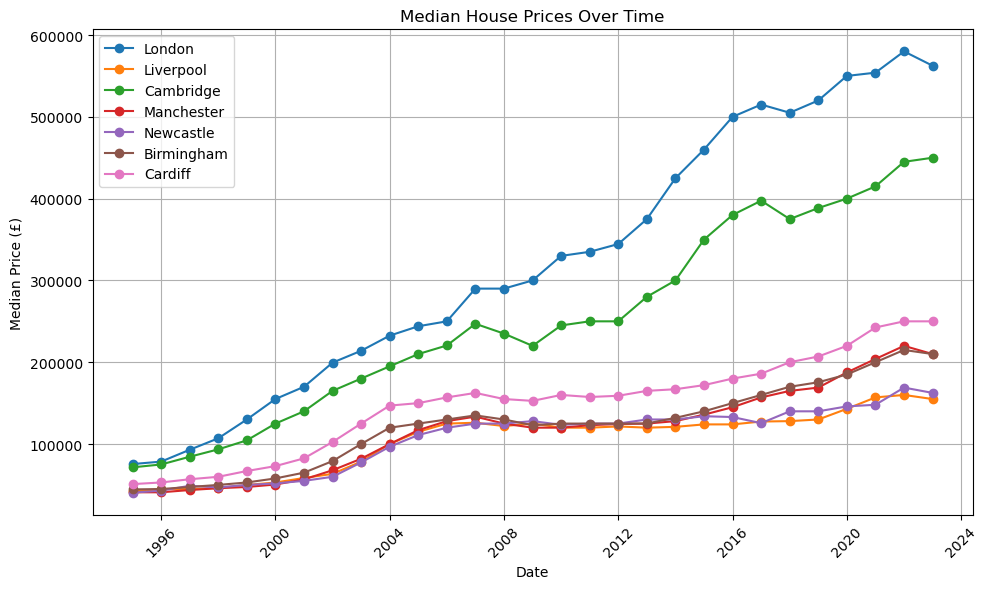

In [3]:
get_graph('test.txt')

In [7]:
import psycopg2
from psycopg2 import sql


conn = psycopg2.connect(database='house_prices', user='postgres', password='Kirt')


cur = conn.cursor()


query = sql.SQL('''
    SELECT EXTRACT(YEAR FROM date_of_transfer) AS year, COUNT(id) AS count
    FROM pp
    GROUP BY year
    ORDER BY year
''')

cur.execute(query)


results = cur.fetchall()


for year, count in results:
    print(f'Year: {year}, Count: {count}')
    
with open('id_counts_per_year.txt', 'w') as file:
    for year, count in results:
        file.write(f'Year: {year}, Count: {count}\n')

print('Results written to id_counts_per_year.txt')


Year: 1995, Count: 2390748
Year: 1996, Count: 2133306
Year: 1997, Count: 2188594
Year: 1998, Count: 2100684
Year: 1999, Count: 2389428
Year: 2000, Count: 2027834
Year: 2001, Count: 1245677
Year: 2002, Count: 1351625
Year: 2003, Count: 1235287
Year: 2004, Count: 1231752
Year: 2005, Count: 1061282
Year: 2006, Count: 1325923
Year: 2007, Count: 1272170
Year: 2008, Count: 649557
Year: 2009, Count: 625220
Year: 2010, Count: 663214
Year: 2011, Count: 661137
Year: 2012, Count: 668829
Year: 2013, Count: 810903
Year: 2014, Count: 984694
Year: 2015, Count: 1010461
Year: 2016, Count: 1045489
Year: 2017, Count: 1066048
Year: 2018, Count: 1035622
Year: 2019, Count: 1008423
Year: 2020, Count: 885146
Year: 2021, Count: 1242597
Year: 2022, Count: 912337
Year: 2023, Count: 273139
Results written to id_counts_per_year.txt


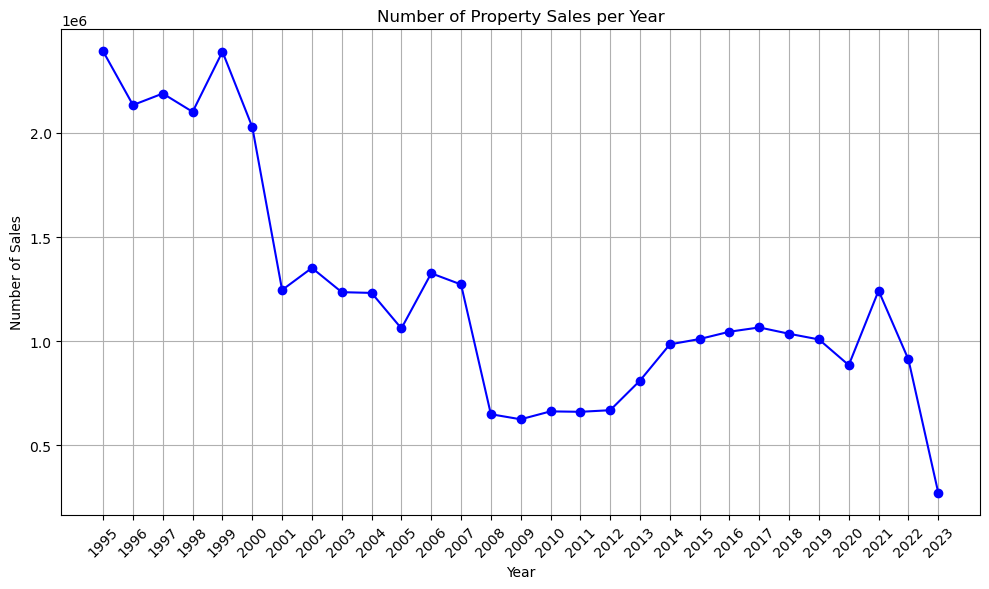

In [9]:
import matplotlib.pyplot as plt

years = []
counts = []

with open('id_counts_per_year.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(', ')
        year = int(parts[0].split(': ')[1])
        count = int(parts[1].split(': ')[1])
        years.append(year)
        counts.append(count)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', color='blue')
plt.xlabel('Year')
plt.ylabel('Number of Sales')
plt.title('Number of Property Sales per Year')
plt.xticks(years, rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


From our analysis we can see that the capital clearly has the most expensive property prices. 
On closer inspection the further north the city the more likey it is to have lower property value. We can see this in heat map generated on Power BI. Properties in the south are more expensive than the north and have a close proximity to London also seems to boost housing prices.

Furthermore we can see huge dips in the sales of properties since 1995. 
There a 3 dips: 
- 1:1999 - 2001 
- 2:2007 - 2008 
- 3:2021 - present

Reason for the dips:
- 1999 - 2001 :  During th 90's there was a recession. During this period of economic downturn, interest rates were raised to 15% and left in place to control inflation. House price fell by 20% from 89-93. The market started to recover during the late 90's, where we start seeing increase in property prices.

- 2007 - 2008 : This one is quite obvious, it has to be the infamous global financial crisis triggered by the collapse of the US housing market. The crisis was caused by a combination of factors, including reckless lending by banks and the widespread use of subprime mortgages. Many homeowner started to face negative equiy where the value of their home is less than the outstanding mortgage.

- 2021 - present : Causeed mainly by the increase in interest rates in the UK, with no real salary increases to keep up with inflation, meaning ordinary working class people cannot afford a loan to buy a house. 